In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
from pylab import mpl, plt
import seaborn as sns

In [6]:
# EURUSD_Daily_201001030000_202110110000.csv
df = pd.read_csv('~/Python/projects/mlfin/data/EURUSD_Daily_201001030000_202110110000.csv',
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date','open', 'high', 'low', 'close', 'tv', 'spread'],
                 sep='\t')

#df['datetime'] = df['date'] + ' ' + df['time']
df['datetime'] = df['date']

df.drop(['date', 'tv', 'spread'], axis= 1, inplace=True)

df.reset_index(drop=True, inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

In [7]:
df.head()

,open,high,low,close
datetime,,,,
2010-01-03,1.43259,1.43336,1.42879,1.42886
2010-01-04,1.42885,1.44543,1.42569,1.44183
2010-01-05,1.44180,1.44830,1.43342,1.43469
2010-01-06,1.43468,1.44456,1.42831,1.44235
2010-01-07,1.44233,1.44259,1.42994,1.43162


<AxesSubplot:xlabel='datetime'>

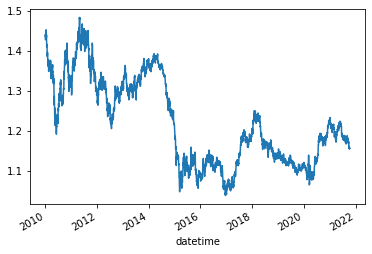

In [8]:
df['close'].plot()

In [9]:
data = pd.DataFrame(df['close'])

In [11]:
data.rename(columns={'close': 'price'}, inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3669 entries, 2010-01-03 to 2021-10-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3669 non-null   float64
dtypes: float64(1)
memory usage: 57.3 KB


In [13]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

In [14]:
data.tail()

,price,SMA1,SMA2
datetime,,,
2021-10-06,1.15553,1.174426,1.196824
2021-10-07,1.15595,1.174146,1.196588
2021-10-08,1.15747,1.173849,1.196341
2021-10-10,1.15657,1.173536,1.196065
2021-10-11,1.15659,1.173111,1.195792


In [16]:
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

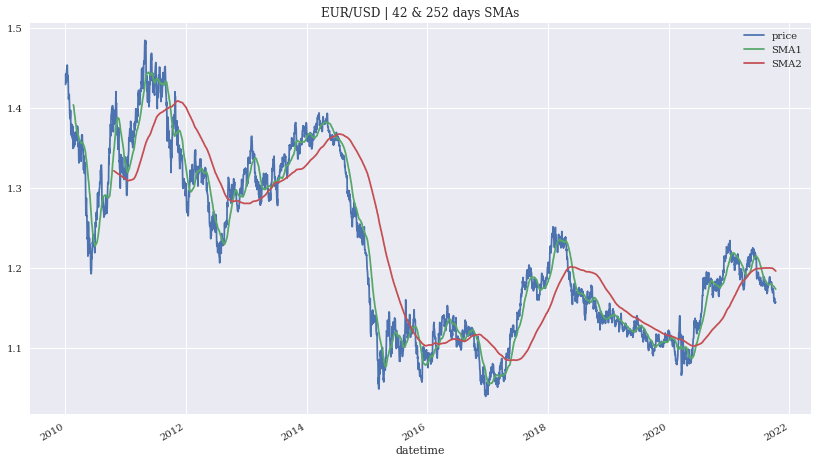

In [18]:
data.plot(title='EUR/USD | 42 & 252 days SMAs',
          figsize=(14,8));

In [19]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [20]:
data.dropna(inplace=True)

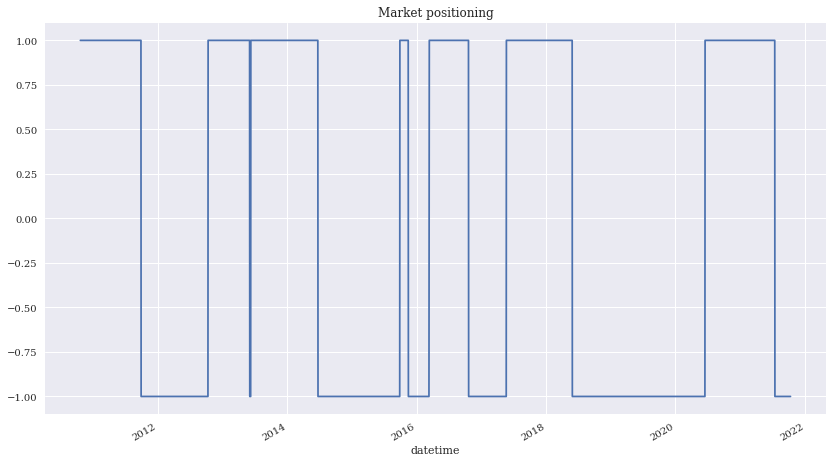

In [21]:
data['position'].plot(ylim=[-1.1, 1.1],
                      title='Market positioning',
                      figsize=(14, 8));

In [22]:
data['returns'] = np.log(data['price']/data['price'].shift(1))

<AxesSubplot:>

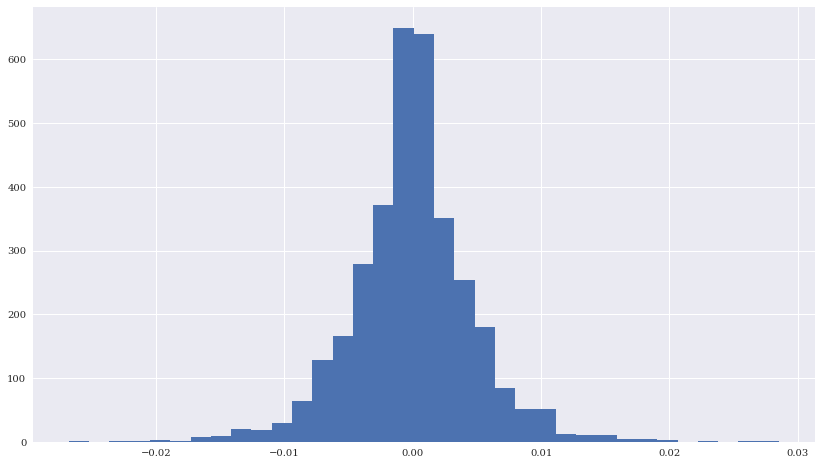

In [24]:
data['returns'].hist(bins=35, figsize=(14,8))

In [25]:
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].sum()

returns    -0.187619
strategy    0.166444
dtype: float64

In [26]:
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.828930
strategy    1.181097
dtype: float64

<AxesSubplot:xlabel='datetime'>

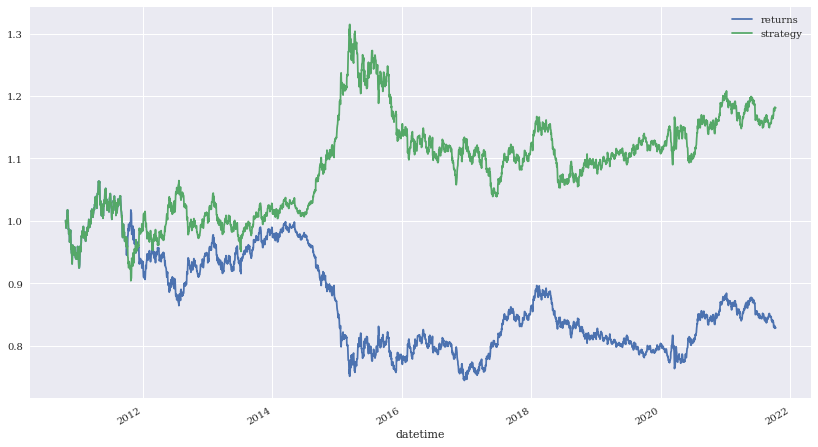

In [27]:
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(14, 8))

Средняя годовая доходность

In [28]:
data[['returns', 'strategy']].mean()*252

returns    -0.013837
strategy    0.012275
dtype: float64

In [29]:
np.exp(data[['returns', 'strategy']].mean()*252) - 1

returns    -0.013741
strategy    0.012351
dtype: float64

Среднее стандартное отклонение

In [30]:
data[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.076150
strategy    0.076151
dtype: float64

In [31]:
(data[['returns', 'strategy']].apply(np.exp) - 1).std() * 252 ** 0.5

returns     0.076148
strategy    0.076133
dtype: float64

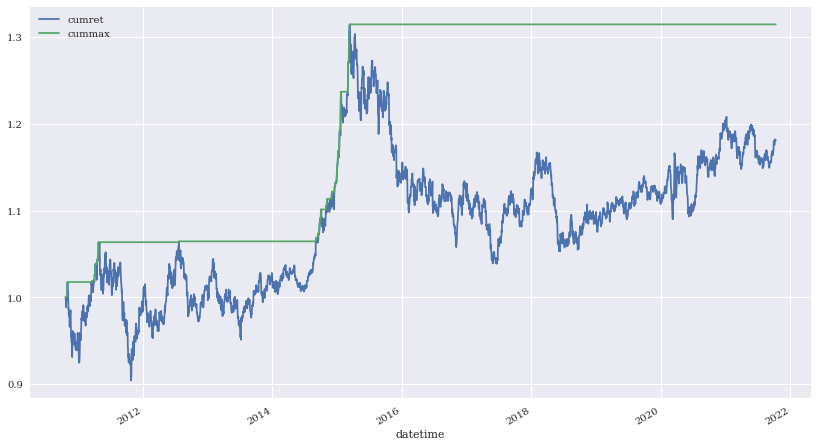

In [32]:
# Общая доходность с течением времени
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

# Текущее максимальное значение общей доходности
data['cummax'] = data ['cumret'].cummax()

# строим на графике новые столбцы
data[['cumret', 'cummax']].dropna().plot(figsize=(14,8));

Работа с классом SMAVectorBachtester из файла SMA_Backtesting

In [41]:
# Импортируем модуль
from SMA_Backtesting import SMAVectorBacktester as SMA

In [49]:
# Создаем экземпляр основного класса
filepath = '~/Python/projects/mlfin/data/EURUSD_Daily_201001030000_202110110000.csv'
smabt = SMA("EURUSD", 42, 252, '2010-01-03', '2019-12-31', filepath)

In [50]:
# Выполняем бектестинг стратегии на основе SMA,
# учитывая параметры, заданные во время создания класса
smabt.run_strategy()

(1.11, 0.31)

In [51]:
# Передаем параметры оптимизации в процедуру и получаем
# на выходе оптимзированные параметры и результаты
# стратегии на них
%%time
smabt.optimize_parameters((30, 50, 2), (200, 300, 2))

CPU times: user 7.41 s, sys: 0 ns, total: 7.41 s
Wall time: 7.43 s


(array([ 34., 282.]), 1.43)

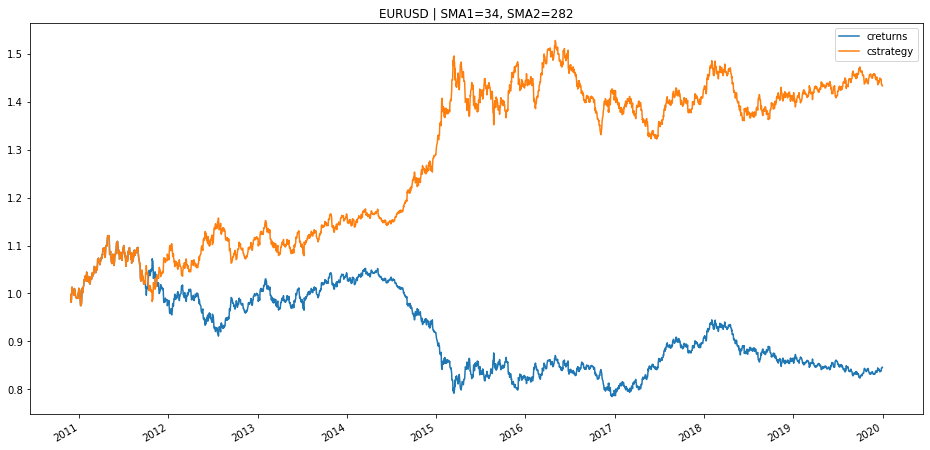

In [52]:
# Строим диаграмму доходности стратегии на 
# оптимизированных папаметрах
smabt.plot_results()